In [ ]:
# =========================================================
#  IT1244 PROJECT: BOOK GENRE CLASSIFICATION
#  Step 1a - Exploratory Data Analysis (EDA) & Cleaning
# =========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from collections import Counter
import nltk
nltk.download('punkt_tab')

# Download NLTK dependencies if not available
nltk.download('punkt')
nltk.download('stopwords')

# ---------------------------------------------------------
# 1️⃣ Load Dataset
# ---------------------------------------------------------
df = pd.read_csv("data.csv")

print("Initial shape:", df.shape)
df.head()


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Initial shape: (4657, 2)


,summary,genre
0,Drowned Wednesday is the first Trustee among ...,1
1,"As the book opens, Jason awakens on a school ...",1
2,Cugel is easily persuaded by the merchant Fia...,1
3,The book opens with Herald-Mage Vanyel return...,1
4,Taran and Gurgi have returned to Caer Dallben...,1


In [ ]:
#Step 1b: Genre mapping (from README)
genre_map = {
    1: 'fantasy',
    2: 'science',
    3: 'crime',
    4: 'history',
    5: 'horror',
    6: 'thriller',
    7: 'psychology',
    8: 'romance',
    9: 'sports',
    10: 'travel'
}

# Replace numeric codes with text
df['genre'] = df['genre'].map(genre_map)

# Verify mapping
print("Unique genre labels:", df['genre'].unique())
df.head()


Unique genre labels: ['fantasy' 'science' 'crime' 'history' 'horror' 'thriller' 'psychology'
 'romance' 'sports' 'travel']


,summary,genre
0,Drowned Wednesday is the first Trustee among ...,fantasy
1,"As the book opens, Jason awakens on a school ...",fantasy
2,Cugel is easily persuaded by the merchant Fia...,fantasy
3,The book opens with Herald-Mage Vanyel return...,fantasy
4,Taran and Gurgi have returned to Caer Dallben...,fantasy


In [ ]:
# Step 2: Check duplicates, missing values, and genre distribution

# Check duplicate rows
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# Remove duplicates
df = df.drop_duplicates().reset_index(drop=True)
print("Shape after removing duplicates:", df.shape)

# Basic info
print("\nDataset Info:")
df.info()

# Check nulls
print("\nMissing values per column:")
print(df.isnull().sum())

# Check genre distribution
print("\nUnique genres:", df['genre'].nunique())
print(df['genre'].value_counts())


Number of duplicate rows: 18
Shape after removing duplicates: (4639, 2)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4639 entries, 0 to 4638
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   summary  4639 non-null   object
 1   genre    4639 non-null   object
dtypes: object(2)
memory usage: 72.6+ KB

Missing values per column:
summary    0
genre      0
dtype: int64

Unique genres: 10
genre
thriller      1022
fantasy        876
science        647
horror         600
history        599
crime          500
romance        111
psychology     100
travel         100
sports          84
Name: count, dtype: int64


/tmp/ipython-input-1044975280.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


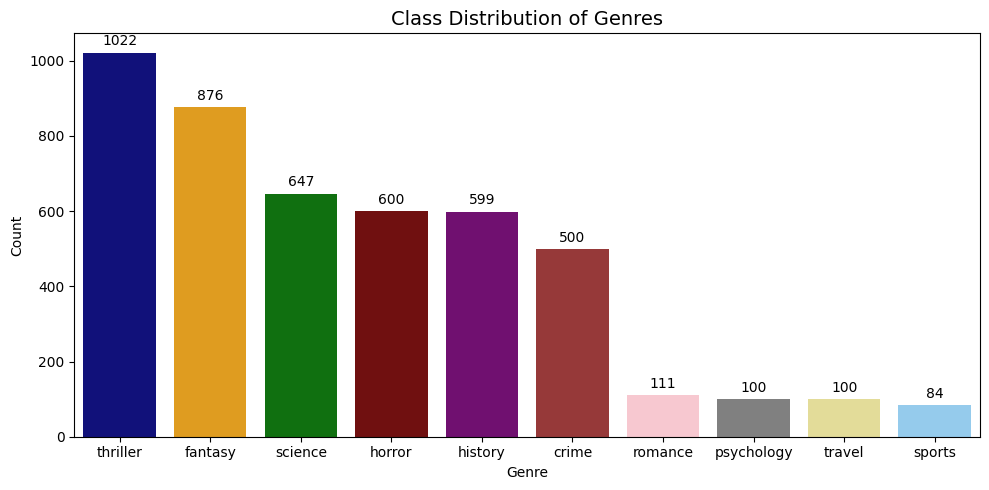

In [ ]:
# Step 3 – Visualize class balance
custom_palette = {
    'thriller': 'darkblue',
    'fantasy': 'orange',
    'science': 'green',
    'horror': 'maroon',
    'history': 'purple',
    'crime': 'brown',
    'romance': 'pink',
    'psychology': 'grey',
    'travel': 'khaki',
    'sports': 'lightskyblue'
}

plt.figure(figsize=(10,5))
ax = sns.countplot(
    x='genre',
    data=df,
    order=df['genre'].value_counts().index,
    palette=custom_palette
)

# Add count labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3, fontsize=10)

plt.title("Class Distribution of Genres", fontsize=14)
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("ClassDistribution.png")
plt.show()



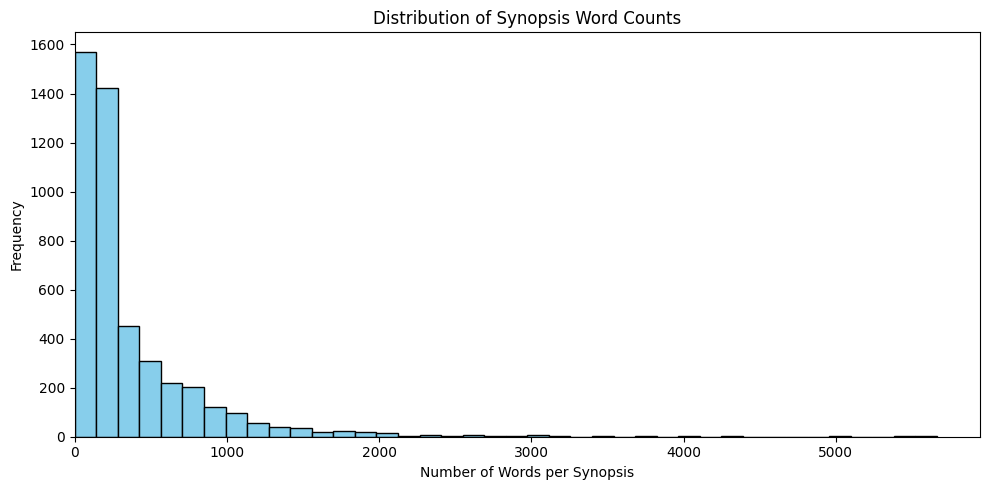

Summary statistics for word count:
count    4639.000000
mean      359.945031
std       438.232965
min         1.000000
25%       118.000000
50%       193.000000
75%       437.000000
max      5663.000000
Name: word_count, dtype: float64
After removing short synopses (<10 words): (4627, 3)


In [ ]:
# Step 4a – Word count distribution
df['word_count'] = df['summary'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10,5))
plt.hist(df['word_count'], bins=40, color='skyblue', edgecolor='black')
plt.title("Distribution of Synopsis Word Counts")
plt.xlabel("Number of Words per Synopsis")
plt.ylabel("Frequency")

# ✅ Force both axes to start from 0
plt.xlim(left=0)
plt.ylim(bottom=0)

plt.tight_layout()
plt.show()

print("Summary statistics for word count:")
print(df['word_count'].describe())

# Remove extremely short synopses (<10 words)
df = df[df['word_count'] >= 10].reset_index(drop=True)
print("After removing short synopses (<10 words):", df.shape)


In [ ]:
#Step 4b

import torch
print("GPU available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


GPU available: True
GPU name: Tesla T4


In [ ]:
#Step 4b Part 2: Pegasus Summariser For Long Synopses

from transformers import PegasusTokenizer, PegasusForConditionalGeneration
import torch
from tqdm import tqdm

# ✅ Load model and tokenizer
model_name = "google/pegasus-large"
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name)

# ✅ Move model to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print(f"Running on: {device}")

# ✅ Summarization function
def summarize_text(text, max_words=300):
    max_tokens = int(max_words * 1.3)
    inputs = tokenizer(
        text,
        truncation=True,
        padding="longest",
        return_tensors="pt",
        max_length=1024
    ).to(device)

    summary_ids = model.generate(
        **inputs,
        max_length=max_tokens,
        num_beams=3,        # fewer beams = faster
        length_penalty=1.0,
        early_stopping=True
    )
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# ✅ Apply to synopses > 500 words (test on small sample first)
long_synopsis_mask = df['word_count'] > 500
long_synopses = df.loc[long_synopsis_mask, 'summary']

print(f"Summarizing {len(long_synopses)} long synopses...")
summaries = []

for text in tqdm(long_synopses.head(10)):  # <— test on first 10 first!
    summaries.append(summarize_text(text))

# ✅ Save back to dataframe
df.loc[long_synopsis_mask, 'summary'].iloc[:len(summaries)] = summaries
print("✅ Summarization completed!")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/260 [00:00<?, ?B/s]

Running on: cuda
Summarizing 1009 long synopses...


100%|██████████| 10/10 [00:24<00:00,  2.42s/it]

✅ Summarization completed!



/tmp/ipython-input-1749530205.py:49: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.loc[long_synopsis_mask, 'summary'].iloc[:len(summaries)] = summaries


In [ ]:
# Step 5 – Token-level cleaning & nonsense filtering
# Load stopwords
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|<.*?>", " ", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stop_words and len(w) > 2]
    return " ".join(tokens)

df['clean_summary'] = df['summary'].apply(clean_text)


In [ ]:
#5.5 Detect and remove nonsensical rows:

nltk.download('words')
english_vocab = set(w.lower() for w in nltk.corpus.words.words())

def is_nonsense(text, threshold=0.7):
    tokens = text.split()
    if len(tokens) == 0:
        return True
    valid = sum(1 for w in tokens if w in english_vocab)
    frac_valid = valid / len(tokens)
    return frac_valid < (1 - threshold)

df['is_nonsense'] = df['clean_summary'].apply(is_nonsense)
print("Potential nonsense samples:", df['is_nonsense'].sum())

df = df[~df['is_nonsense']].reset_index(drop=True)
df.drop(columns=['is_nonsense'], inplace=True)
print("After removing nonsense:", df.shape)



[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


Potential nonsense samples: 14
After removing nonsense: (4613, 4)


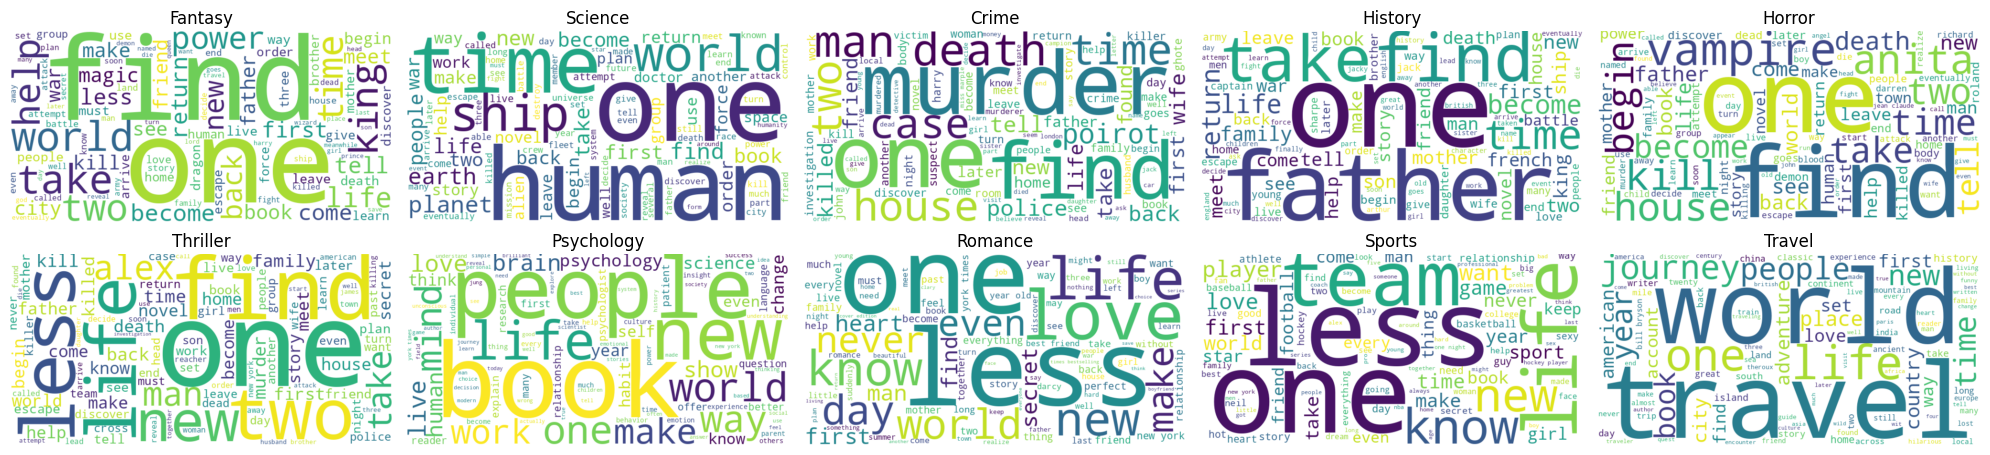

In [ ]:
# Step 6 – Word clouds by genre
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get unique genres
genres = df['genre'].unique()

# Create a 2x5 grid for 10 genres
fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # adjust size as needed
axes = axes.flatten()  # flatten 2D array of axes for easy iteration

for i, g in enumerate(genres):
    subset = df[df['genre'] == g]
    text = " ".join(subset['clean_summary'].values)

    # Generate word cloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=100
    ).generate(text)

    # Plot on the corresponding subplot
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f"{g.title()}", fontsize=12)

# Hide any extra empty subplots (if <10 genres)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# ✅ Reduce vertical spacing between rows
plt.subplots_adjust(hspace=-0.7, wspace=0.1)  # smaller hspace = less vertical gap
plt.tight_layout(rect=[0, 0, 1, 0.96])  # optional: leaves slight margin around figure

plt.savefig("WordClouds.png")
plt.show()


In [ ]:
#Step 7 – Save cleaned dataset

print("Final dataset shape:", df.shape)
print(df[['summary', 'clean_summary', 'genre']].sample(3, random_state=42))

df[['clean_summary', 'genre']].to_csv("cleaned_books.csv", index=False)
print("✅ Cleaned dataset saved as cleaned_books.csv")

Final dataset shape: (4613, 4)
                                                summary  \
1073   In a flashback from late Spring to early Spri...   
2750   The book starts off during the second America...   
1374   Tessa is the story of Tessa, a sixteen-year-o...   

                                          clean_summary     genre  
1073  flashback late spring early spring lynn marchm...     crime  
2750  book starts second american civil war islamic ...  thriller  
1374  tessa story tessa sixteen year old schoolgirl ...     crime  
✅ Cleaned dataset saved as cleaned_books.csv


In [ ]:
# Feeding data into models

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout
from tqdm import tqdm
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    get_linear_schedule_with_warmup,
)
from torch.optim import AdamW
import torch
from torch.utils.data import DataLoader, Dataset

In [ ]:
# ---------------------------------------------------------
# Baseline Model (TF-IDF + Logistic Regression) + 5-Fold CV
# ---------------------------------------------------------

df = pd.read_csv("cleaned_books.csv")

print(df.head())
print("\nColumns:", df.columns)


X = df['clean_summary']
y = df['genre']

# TF-IDF Vectorization (fit on full data before CV)
vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 2)
)
X_tfidf = vectorizer.fit_transform(X)

# Define model
model = LogisticRegression(max_iter=2000)

# Perform 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred = cross_val_predict(model, X_tfidf, y, cv=skf)

# Compute metrics
accuracy = accuracy_score(y, y_pred)
macro_f1 = f1_score(y, y_pred, average='macro')

print(f"\n✅ 5-Fold Cross-Validation Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro-F1: {macro_f1:.4f}\n")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y, y_pred))


                                       clean_summary    genre
0  drowned wednesday first trustee among morrow d...  fantasy
1  book opens jason awakens school bus unable rem...  fantasy
2  cugel easily persuaded merchant fianosther att...  fantasy
3  book opens herald mage vanyel returning countr...  fantasy
4  taran gurgi returned caer dallben following ev...  fantasy

Columns: Index(['clean_summary', 'genre'], dtype='object')

✅ 5-Fold Cross-Validation Results:
Accuracy: 0.6558
Macro-F1: 0.4731


Classification Report:
              precision    recall  f1-score   support

       crime       0.82      0.54      0.65       499
     fantasy       0.69      0.79      0.73       872
     history       0.73      0.72      0.73       597
      horror       0.67      0.52      0.59       596
  psychology       0.82      0.14      0.24        99
     romance       0.33      0.01      0.02       111
     science       0.71      0.72      0.72       640
      sports       0.87      0.15      0

In [ ]:

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip


--2025-10-30 12:21:35--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-10-30 12:21:35--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-10-30 12:21:35--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
# ------------------------------
# Word Embeddings + Shallow NN + 5-Fold CV
# ------------------------------

# 2️⃣ Load dataset
df = pd.read_csv("cleaned_books.csv")
X_text = df['clean_summary']  # text column
y = df['genre']               # labels

# 3️⃣ Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 4️⃣ Tokenize and pad sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_text)
sequences = tokenizer.texts_to_sequences(X_text)
max_len = 100
X_padded = pad_sequences(sequences, maxlen=max_len, padding='post')

# 5️⃣ Load GloVe embeddings
embedding_index = {}
with open("glove.6B.100d.txt", encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        embedding_index[word] = vector

# 6️⃣ Create embedding matrix
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    vector = embedding_index.get(word)
    if vector is not None:
        embedding_matrix[i] = vector

# 7️⃣ Define a function to build the model (so we can recreate it each fold)
def create_model():
    num_classes = len(le.classes_)
    model = Sequential([
        Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                  input_length=max_len, trainable=False),
        Bidirectional(LSTM(64, return_sequences=False)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# 8️⃣ 5-Fold Cross Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
acc_scores = []

all_y_true = []
all_y_pred = []

for train_idx, test_idx in kf.split(X_padded, y_encoded):
    print(f"\n===== Fold {fold} =====")

    X_train, X_test = X_padded[train_idx], X_padded[test_idx]
    y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

    model = create_model()

    history = model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=32,
        validation_split=0.1,
        verbose=1
    )

    y_pred = np.argmax(model.predict(X_test), axis=1)
    acc = accuracy_score(y_test, y_pred)
    acc_scores.append(acc)
    print(f"Fold {fold} Accuracy: {acc:.4f}")

    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

    fold += 1

# 9️⃣ Final evaluation
print("\n===== Cross-Validation Results =====")
print(f"Mean Accuracy: {np.mean(acc_scores):.4f} ± {np.std(acc_scores):.4f}")

print("\nClassification Report (Aggregated):\n")
print(classification_report(all_y_true, all_y_pred, target_names=le.classes_))



===== Fold 1 =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.2426 - loss: 2.0595 - val_accuracy: 0.0108 - val_loss: 2.7425
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4083 - loss: 1.6281 - val_accuracy: 0.3008 - val_loss: 2.0778
Epoch 3/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4973 - loss: 1.3752 - val_accuracy: 0.1409 - val_loss: 2.6590
Epoch 4/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5361 - loss: 1.2675 - val_accuracy: 0.0407 - val_loss: 3.7194
Epoch 5/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5991 - loss: 1.1213 - val_accuracy: 0.0434 - val_loss: 4.6826
Epoch 6/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6296 - loss: 1.0156 - val_accuracy: 0.0298 - val_loss: 4.5373
Epoch 7/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6816 - loss: 0.9297 - val_accuracy: 0.0515 - val_loss: 4.9197
Epoch 8/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6969 - loss: 0.8741 - val_accu

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.2396 - loss: 2.0773 - val_accuracy: 0.1355 - val_loss: 2.4442
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4172 - loss: 1.5860 - val_accuracy: 0.3604 - val_loss: 2.1856
Epoch 3/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4943 - loss: 1.3792 - val_accuracy: 0.1734 - val_loss: 2.6226
Epoch 4/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5761 - loss: 1.2208 - val_accuracy: 0.0813 - val_loss: 2.9484
Epoch 5/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5849 - loss: 1.1352 - val_accuracy: 0.0759 - val_loss: 3.4548
Epoch 6/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6392 - loss: 1.0292 - val_accuracy: 0.0569 - val_loss: 3.4648
Epoch 7/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6331 - loss: 1.0058 - val_accuracy: 0.0569 - val_loss: 3.4754
Epoch 8/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6754 - loss: 0.9299 - val_accuracy: 0.037

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.2412 - loss: 2.0767 - val_accuracy: 0.0027 - val_loss: 2.4917
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.3930 - loss: 1.6029 - val_accuracy: 0.3279 - val_loss: 1.9849
Epoch 3/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5012 - loss: 1.3868 - val_accuracy: 0.2439 - val_loss: 2.1856
Epoch 4/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5762 - loss: 1.2067 - val_accuracy: 0.0678 - val_loss: 3.0224
Epoch 5/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5781 - loss: 1.1286 - val_accuracy: 0.0379 - val_loss: 3.5387
Epoch 6/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6296 - loss: 1.0338 - val_accuracy: 0.1247 - val_loss: 3.1984
Epoch 7/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6521 - loss: 0.9443 - val_accuracy: 0.1626 - val_loss: 3.2041
Epoch 8/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7075 - loss: 0.8350 - val_accuracy: 0.132

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.2304 - loss: 2.0487 - val_accuracy: 0.0378 - val_loss: 2.8373
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3737 - loss: 1.6226 - val_accuracy: 0.1162 - val_loss: 2.5654
Epoch 3/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4956 - loss: 1.3896 - val_accuracy: 0.2595 - val_loss: 2.3531
Epoch 4/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5412 - loss: 1.2271 - val_accuracy: 0.1649 - val_loss: 2.9698
Epoch 5/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5485 - loss: 1.2113 - val_accuracy: 0.1622 - val_loss: 3.1279
Epoch 6/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6218 - loss: 1.0556 - val_accuracy: 0.1000 - val_loss: 3.7903
Epoch 7/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6896 - loss: 0.9105 - val_accuracy: 0.0946 - val_loss: 3.5375
Epoch 8/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6735 - loss: 0.9070 - val_accuracy: 0.024

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.2171 - loss: 2.0587 - val_accuracy: 0.3486 - val_loss: 2.3765
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4480 - loss: 1.5027 - val_accuracy: 0.1703 - val_loss: 2.8619
Epoch 3/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5131 - loss: 1.3222 - val_accuracy: 0.1324 - val_loss: 2.8001
Epoch 4/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5378 - loss: 1.2604 - val_accuracy: 0.0946 - val_loss: 3.4616
Epoch 5/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6101 - loss: 1.0928 - val_accuracy: 0.0189 - val_loss: 4.5110
Epoch 6/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6270 - loss: 0.9954 - val_accuracy: 0.0838 - val_loss: 4.1693
Epoch 7/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6673 - loss: 0.9175 - val_accuracy: 0.0757 - val_loss: 4.1728
Epoch 8/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6793 - loss: 0.8875 - val_accuracy: 0.040

In [ ]:
# ------------------------------
# Frozen BERT Embeddings + Logistic Regresssion + 5-Fold CV
# ------------------------------

# --- Step 0: Imports ---
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import cross_val_score, cross_val_predict


# --- Step 1: Load dataset ---
df = pd.read_csv("cleaned_books.csv")
texts = df['clean_summary'].tolist()
labels = df['genre'].astype('category').cat.codes  # Encode labels as integers

print(f"Dataset size: {len(df)} | Classes: {df['genre'].nunique()}")

# --- Step 2: Load frozen BERT model & tokenizer ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model = bert_model.to(device)
bert_model.eval()  # ❄️ Freeze BERT (no fine-tuning)

# --- Step 3: Get BERT embeddings (CLS token representation) ---
def get_bert_embeddings(texts, batch_size=16):
    embeddings = []
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size)):
            batch = texts[i:i+batch_size]
            encoded = tokenizer(batch, padding=True, truncation=True, max_length=128, return_tensors='pt')
            encoded = {k: v.to(device) for k, v in encoded.items()}
            outputs = bert_model(**encoded)
            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(cls_embeddings)
    return np.vstack(embeddings)

print("Extracting frozen BERT embeddings...")
X = get_bert_embeddings(texts)
y = labels.values
print(f"Embeddings shape: {X.shape}")

# --- Step 4: Logistic Regression + 5-fold CV ---
clf = LogisticRegression(max_iter=2000, solver='lbfgs', class_weight='balanced')

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
print("\n✅ Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores).round(4))

# --- Step 5: Classification Report (using CV predictions) ---
y_pred = cross_val_predict(clf, X, y, cv=cv)
print("\n📊 Classification Report:")
print(classification_report(y, y_pred, target_names=df['genre'].astype('category').cat.categories))

Dataset size: 4613 | Classes: 10


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Extracting frozen BERT embeddings...


100%|██████████| 289/289 [00:47<00:00,  6.08it/s]


Embeddings shape: (4613, 768)

✅ Cross-Validation Accuracy Scores: [0.65872156 0.63705309 0.65438787 0.64425163 0.6681128 ]
Mean CV Accuracy: 0.6525

📊 Classification Report:
              precision    recall  f1-score   support

       crime       0.58      0.66      0.62       499
     fantasy       0.75      0.68      0.71       872
     history       0.67      0.71      0.69       597
      horror       0.54      0.58      0.56       596
  psychology       0.69      0.83      0.76        99
     romance       0.34      0.50      0.40       111
     science       0.68      0.68      0.68       640
      sports       0.72      0.81      0.76        84
    thriller       0.69      0.59      0.64      1015
      travel       0.75      0.88      0.81       100

    accuracy                           0.65      4613
   macro avg       0.64      0.69      0.66      4613
weighted avg       0.66      0.65      0.65      4613



In [ ]:
# ==============================
# Frozen BERT + PCA + Logistic Regression + 5-Fold CV
# ==============================

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from transformers import AutoTokenizer, AutoModel
import torch

# ------------------------------
# Load your dataset
# ------------------------------

df = pd.read_csv("cleaned_books.csv")
texts = df['clean_summary'].tolist()
labels = df['genre'].tolist()

# ------------------------------
# Load pretrained BERT (frozen)
# ------------------------------
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased")
model.eval()  # disable dropout
for param in model.parameters():
    param.requires_grad = False  # freeze weights

# ------------------------------
# Function to get BERT embeddings
# ------------------------------
def get_bert_embeddings(texts, batch_size=16, max_length=128):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(
            batch,
            padding=True,
            truncation=True,
            return_tensors="pt",
            max_length=max_length
        )
        with torch.no_grad():
            outputs = model(**inputs)
            # Use [CLS]-equivalent token (DistilBERT uses the first token)
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

# Generate embeddings
print("Generating BERT embeddings...")
X = get_bert_embeddings(texts)

# ------------------------------
# Apply PCA for dimensionality reduction
# ------------------------------
pca = PCA(n_components=100)  # keep 100 principal components
X_reduced = pca.fit_transform(X)
print(f"Reduced embedding size from {X.shape[1]} to {X_reduced.shape[1]}")

# ------------------------------
# Logistic Regression + 5-Fold CV
# ------------------------------
clf = LogisticRegression(max_iter=1000, C=1.0, random_state=42)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []
y_true_all, y_pred_all = [], []

for train_idx, test_idx in skf.split(X_reduced, labels):
    X_train, X_test = X_reduced[train_idx], X_reduced[test_idx]
    y_train, y_test = np.array(labels)[train_idx], np.array(labels)[test_idx]

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accuracies.append(accuracy_score(y_test, y_pred))
    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)

print("\n=== Cross-Validation Results ===")
print(f"Average Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")

print("\n=== Classification Report ===")
print(classification_report(y_true_all, y_pred_all))


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Generating BERT embeddings...
Reduced embedding size from 768 to 100

=== Cross-Validation Results ===
Average Accuracy: 0.6820 ± 0.0076

=== Classification Report ===
              precision    recall  f1-score   support

       crime       0.64      0.60      0.62       499
     fantasy       0.73      0.75      0.74       872
     history       0.71      0.71      0.71       597
      horror       0.60      0.55      0.57       596
  psychology       0.76      0.72      0.74        99
     romance       0.48      0.34      0.40       111
     science       0.71      0.72      0.72       640
      sports       0.87      0.82      0.85        84
    thriller       0.64      0.71      0.67      1015
      travel       0.84      0.84      0.84       100

    accuracy                           0.68      4613
   macro avg       0.70      0.68      0.69      4613
weighted avg       0.68      0.68      0.68      4613



In [ ]:
# ------------------------------
# DistilBERT + Weighted Loss + Longer Texts + 5-Fold CV
# ------------------------------

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight

# --- Step 1: Load dataset ---
df = pd.read_csv("cleaned_books.csv").reset_index(drop=True)
texts = df["clean_summary"].tolist()
labels = df["genre"].astype("category").cat.codes.to_numpy()
num_classes = df["genre"].nunique()
print(f"Dataset size: {len(df)} | Classes: {num_classes}")

# --- Step 2: Tokenizer & device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# --- Step 3: Dataset class ---
class BookDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):  # ⬅️ longer text window
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )
        item = {k: v.squeeze(0) for k, v in encoding.items()}
        item["labels"] = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return item

# --- Step 4: Train one fold ---
def train_one_fold(model, train_loader, val_loader, class_weights, epochs=4, lr=3e-5):  # ⬅️ more epochs, slightly higher LR
    optimizer = AdamW(model.parameters(), lr=lr)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=total_steps
    )

    loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)  # ⬅️ weighted loss

    model.to(device)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = loss_fn(outputs.logits, batch["labels"])  # ⬅️ custom weighted loss
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} | Training Loss: {total_loss/len(train_loader):.4f}")

    # --- Evaluate ---
    model.eval()
    preds, true = [], []
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            preds.extend(outputs.logits.argmax(dim=1).cpu().numpy())
            true.extend(batch["labels"].cpu().numpy())

    acc = accuracy_score(true, preds)
    return acc, preds, true

# --- Step 5: 5-Fold Cross Validation ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc_scores = []
all_preds, all_true = [], []

# compute class weights once (global)
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class Weights:", class_weights)

import os
import shutil

# Create folder to store the best model
os.makedirs("Model_Dataset", exist_ok=True)

best_acc = 0.0
best_fold = None
best_model_path = "Model_Dataset/best_model"

for fold, (train_idx, val_idx) in enumerate(kf.split(texts, labels)):
    print(f"\n🔁 Fold {fold+1}")

    train_texts = np.array(texts)[train_idx]
    val_texts = np.array(texts)[val_idx]
    y_train = labels[train_idx]
    y_val = labels[val_idx]

    train_dataset = BookDataset(train_texts, y_train, tokenizer, max_len=256)
    val_dataset = BookDataset(val_texts, y_val, tokenizer, max_len=256)

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8)

    model = DistilBertForSequenceClassification.from_pretrained(
        "distilbert-base-uncased", num_labels=num_classes
    )

    acc, preds, true = train_one_fold(model, train_loader, val_loader, class_weights)
    acc_scores.append(acc)
    all_preds.extend(preds)
    all_true.extend(true)
    print(f"Fold {fold+1} Accuracy: {acc:.4f}")

    # extract model part
    # ✅ Save temporarily if this is the best model so far
    if acc > best_acc:
        best_acc = acc
        best_fold = fold + 1

        # Clear previous best model folder
        if os.path.exists(best_model_path):
            shutil.rmtree(best_model_path)

        model.save_pretrained(best_model_path)
        tokenizer.save_pretrained(best_model_path)
        print(f"🌟 New best model found at Fold {best_fold} with Acc = {best_acc:.4f}")


# --- Step 6: Summary ---
print("\n✅ Cross-Validation Accuracies:", np.round(acc_scores, 4))
print("Mean CV Accuracy:", np.mean(acc_scores).round(4))

print("\n📊 Classification Report:")
print(classification_report(all_true, all_preds, target_names=df["genre"].astype("category").cat.categories))


Dataset size: 4613 | Classes: 10
Class Weights: tensor([0.9244, 0.5290, 0.7727, 0.7740, 4.6596, 4.1559, 0.7208, 5.4917, 0.4545,
        4.6130], device='cuda:0')

🔁 Fold 1


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 462/462 [01:38<00:00,  4.67it/s]


Epoch 1 | Training Loss: 1.4325


Epoch 2: 100%|██████████| 462/462 [01:37<00:00,  4.72it/s]


Epoch 2 | Training Loss: 0.6640


Epoch 3: 100%|██████████| 462/462 [01:38<00:00,  4.71it/s]


Epoch 3 | Training Loss: 0.4325


Epoch 4: 100%|██████████| 462/462 [01:37<00:00,  4.72it/s]


Epoch 4 | Training Loss: 0.3049
Fold 1 Accuracy: 0.7736
🌟 New best model found at Fold 1 with Acc = 0.7736

🔁 Fold 2


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 462/462 [01:38<00:00,  4.71it/s]


Epoch 1 | Training Loss: 1.5212


Epoch 2: 100%|██████████| 462/462 [01:38<00:00,  4.71it/s]


Epoch 2 | Training Loss: 0.7128


Epoch 3: 100%|██████████| 462/462 [01:38<00:00,  4.70it/s]


Epoch 3 | Training Loss: 0.4518


Epoch 4: 100%|██████████| 462/462 [01:38<00:00,  4.71it/s]


Epoch 4 | Training Loss: 0.3178
Fold 2 Accuracy: 0.7584

🔁 Fold 3


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 462/462 [01:38<00:00,  4.70it/s]


Epoch 1 | Training Loss: 1.3038


Epoch 2: 100%|██████████| 462/462 [01:38<00:00,  4.69it/s]


Epoch 2 | Training Loss: 0.6139


Epoch 3: 100%|██████████| 462/462 [01:38<00:00,  4.70it/s]


Epoch 3 | Training Loss: 0.3972


Epoch 4: 100%|██████████| 462/462 [01:38<00:00,  4.71it/s]


Epoch 4 | Training Loss: 0.2789
Fold 3 Accuracy: 0.7573

🔁 Fold 4


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 462/462 [01:38<00:00,  4.70it/s]


Epoch 1 | Training Loss: 1.3682


Epoch 2: 100%|██████████| 462/462 [01:38<00:00,  4.69it/s]


Epoch 2 | Training Loss: 0.6529


Epoch 3: 100%|██████████| 462/462 [01:38<00:00,  4.68it/s]


Epoch 3 | Training Loss: 0.4474


Epoch 4: 100%|██████████| 462/462 [01:38<00:00,  4.70it/s]


Epoch 4 | Training Loss: 0.3105
Fold 4 Accuracy: 0.7430

🔁 Fold 5


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 462/462 [01:46<00:00,  4.35it/s]


Epoch 1 | Training Loss: 1.3391


Epoch 2: 100%|██████████| 462/462 [01:40<00:00,  4.58it/s]


Epoch 2 | Training Loss: 0.6285


Epoch 3: 100%|██████████| 462/462 [01:45<00:00,  4.39it/s]


Epoch 3 | Training Loss: 0.4122


Epoch 4: 100%|██████████| 462/462 [01:38<00:00,  4.69it/s]


Epoch 4 | Training Loss: 0.2938
Fold 5 Accuracy: 0.7505

✅ Cross-Validation Accuracies: [0.7736 0.7584 0.7573 0.743  0.7505]
Mean CV Accuracy: 0.7566

📊 Classification Report:
              precision    recall  f1-score   support

       crime       0.71      0.77      0.73       499
     fantasy       0.82      0.78      0.80       872
     history       0.80      0.82      0.81       597
      horror       0.65      0.71      0.68       596
  psychology       0.79      0.86      0.82        99
     romance       0.49      0.67      0.56       111
     science       0.75      0.80      0.77       640
      sports       0.87      0.88      0.88        84
    thriller       0.80      0.67      0.73      1015
      travel       0.88      0.86      0.87       100

    accuracy                           0.76      4613
   macro avg       0.75      0.78      0.77      4613
weighted avg       0.76      0.76      0.76      4613

